## KELOMPOK 6 - DEVISVE CLUSTERING

Permasalahan utama yang ingin dipecahkan adalah mengidentifikasi dan mengelompokkan pola transaksi yang beragam dalam dataset penjualan.kami menerapkan metode Divisive Clustering (Top-Down).


Diharapkan hasil ini memberikan profil statistik yang jelas dan terpisah, memungkinkan identifikasi kelompok transaksi dengan karakteristik unik (misalnya, klaster dengan nilai total tertinggi atau klaster dengan jumlah order terbanyak).

## **Divisive Clustering (Top-Down):**

• Memulai dengan satu klaster yang berisi semua titik data.

• Secara bertahap memisahkan klaster menjadi klaster yang lebih kecil.

Langkah-langkah:

1. Load data

2. Mengecek Tipe Data & Missing Value

3. Preprocessing
4. Menentukan k optimal

5. Split awal (1 → 2 klaster)

6. Split lanjutan (pilih klaster terbesar → pecah lagi)

7. Visualisasi

8. Evaluasi (SSE & Silhouette)

---

In [ ]:
# Library Import
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

In [ ]:
# Membaca dataset
df = pd.read_csv('/content/data_penjualan.csv', delimiter=';')

df.head()


,Tanggal,Jenis Produk,Jumlah Order,Harga,Total
0,05/08/2022,Foodpak260,1000,1800,1800000
1,05/08/2022,FoodpakMatte245,1000,1900,1900000
2,05/08/2022,CraftLaminasi290,5000,750,3750000
3,05/08/2022,CraftLaminasi290,1000,1200,1200000
4,07/08/2022,Dupleks310,1000,1550,1550000


In [ ]:
# Mengecek Tipe Data dan Missing Value
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tanggal       1076 non-null   object
 1   Jenis Produk  1076 non-null   object
 2   Jumlah Order  1076 non-null   int64 
 3   Harga         1076 non-null   int64 
 4   Total         1076 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.2+ KB


,0
Tanggal,0
Jenis Produk,0
Jumlah Order,0
Harga,0
Total,0


In [ ]:
# PREPROCESSING – hanya pakai fitur numerik (Divisive clustering hanya bisa memproses data numerik)

# Pilih kolom numerik untuk clustering
features = ['Jumlah Order', 'Harga', 'Total']
X = df[features].copy()
X.head()

,Jumlah Order,Harga,Total
0,1000,1800,1800000
1,1000,1900,1900000
2,5000,750,3750000
3,1000,1200,1200000
4,1000,1550,1550000


In [ ]:
# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

Sebelum mengelompokkan data, kami memvisualisasikan hirarki Divisive Clustering menggunakan Dendrogram. Kami mengidentifikasi celah disimilaritas terbesar, yang menjustifikasi bahwa $k=3$ adalah jumlah klaster yang paling optimal.

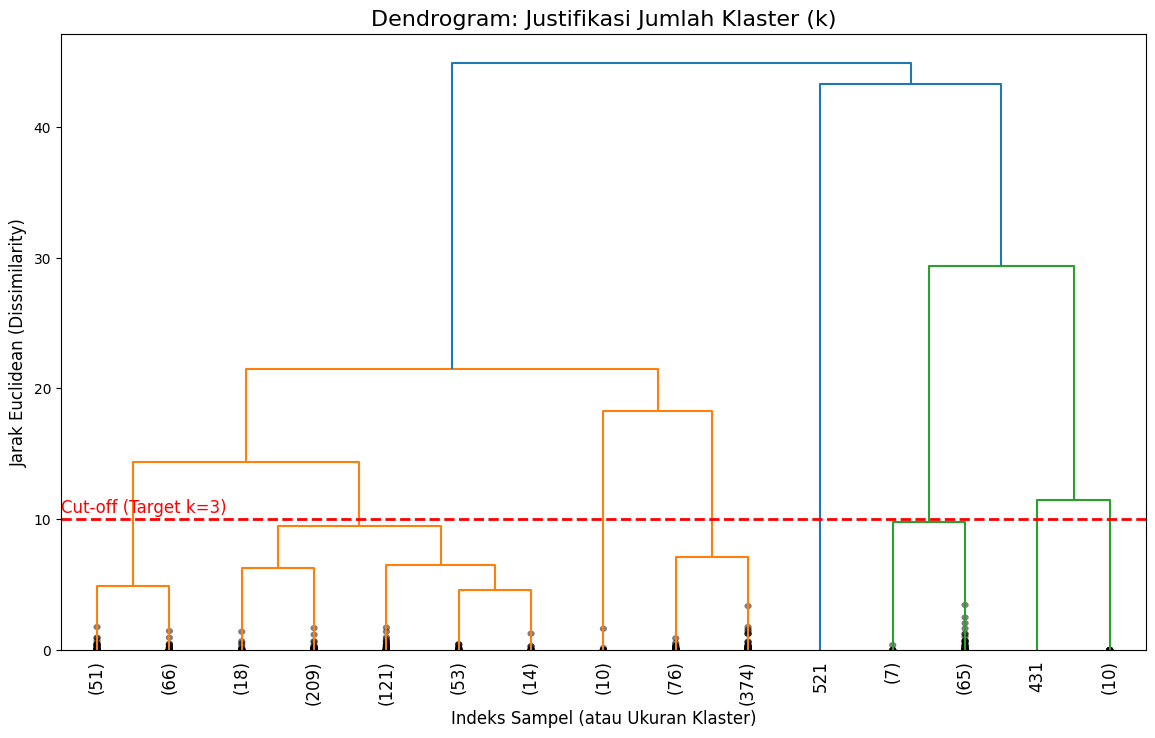

In [ ]:
# PERHITUNGAN LINKAGE & PLOT DENDROGRAM

# Menghitung Matriks Linkage (Z)
# Menggunakan metode 'ward' yang umumnya direkomendasikan untuk menghasilkan klaster kompak.
Z = sch.linkage(X_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(14, 8))
dendro = sch.dendrogram(Z,
                    truncate_mode='lastp', # Menampilkan hanya 15 klaster terakhir untuk keterbacaan
                    p=15,
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True)

plt.title('Dendrogram: Justifikasi Jumlah Klaster (k)', fontsize=16)
plt.xlabel('Indeks Sampel (atau Ukuran Klaster)', fontsize=12)
plt.ylabel('Jarak Euclidean (Dissimilarity)', fontsize=12)

# Garis Potong (Cut-off) untuk Menjustifikasi k=3
# Sesuaikan nilai Y=10.0 ini berdasarkan visual Dendrogram Anda yang sebenarnya!
cut_off_y = 10.0
plt.axhline(y=cut_off_y, color='r', linestyle='--', linewidth=2)
plt.text(0, cut_off_y + 0.5, f'Cut-off (Target k=3)', color='r', fontsize=12)

plt.show()

In [ ]:
# DIVISIVE CLUSTERING SEDERHANA
# Tahap 1: Pisahkan data menjadi 2 cluster

# Awalnya semua data dianggap berada dalam 1 cluster besar
df["cluster"] = 0   # semua data = cluster 0

kmeans_1 = KMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_1.fit_predict(X_scaled)

df["cluster"] = labels_2   # update dari cluster besar → 2 klaster

df["cluster"].value_counts()

,count
cluster,
0,972
1,104


In [ ]:
# 6. Tahap 2: Pilih cluster yang terbesar → pecah lagi

# Ambil cluster yang ukurannya paling besar
largest_cluster = df["cluster"].value_counts().idxmax()

# Ambil data dari cluster tersebut
subset = X_scaled[df["cluster"] == largest_cluster]

# Split cluster besar menjadi 2 bagian
kmeans_split = KMeans(n_clusters=2, random_state=42)
split_labels = kmeans_split.fit_predict(subset)

# Map label split baru ke label global
new_label_id = df["cluster"].max() + 1

# Update cluster label pada dataframe
idx_subset = df[df["cluster"] == largest_cluster].index
df.loc[idx_subset[split_labels == 1], "cluster"] = new_label_id

df["cluster"].value_counts()


,count
cluster,
2,693
0,279
1,104


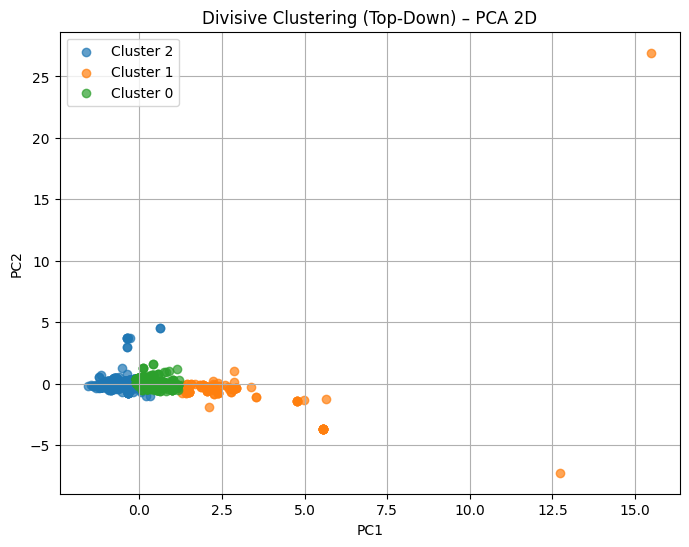

In [ ]:
# 7. VISUALISASI

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for k in df["cluster"].unique():
    plt.scatter(
        X_pca[df["cluster"]==k, 0],
        X_pca[df["cluster"]==k, 1],
        label=f"Cluster {k}",
        alpha=0.7
    )

plt.title("Divisive Clustering (Top-Down) – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# EVALUASI

# SSE per cluster
def sse(X, labels):
    sse_total = 0
    for k in np.unique(labels):
        group = X[labels==k]
        centroid = group.mean(axis=0)
        sse_total += ((group - centroid)**2).sum()
    return sse_total

total_sse = sse(X_scaled, df["cluster"].values)
silhouette = silhouette_score(X_scaled, df["cluster"].values)

print("SSE:", total_sse)
print("Silhouette Score:", silhouette)

SSE: 1945.623837612074
Silhouette Score: 0.46421257915948627


Hasil Evaluasi :

- Nilai SSE kami adalah 1945.62. Nilai ini menunjukkan bahwa penyebaran data dalam klaster tergolong cukup rapat, dan pemisahan klaster yang terbentuk stabil meskipun tidak sepenuhnya optimal.

- Silhouette Score kami sebesar 0.464 menunjukkan bahwa kualitas klaster yang terbentuk sudah cukup baik. Data dalam satu klaster cenderung mirip satu sama lain dan cukup terpisah dari klaster lainnya. Namun, masih terdapat sebagian data yang berada dekat dengan batas antar klaster.